<a href="https://colab.research.google.com/github/ajitkumarkp/ML/blob/master/Training_YOLO_for_LP_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [0]:
%mkdir ALPR

In [4]:
%cd ALPR/

/content/drive/My Drive/ALPR


# 1. Download Darknet Framework and compile it


In [5]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13152 (delta 4), reused 4 (delta 1), pack-reused 13139
Receiving objects: 100% (13152/13152), 11.90 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (8987/8987), done.
Checking out files: 100% (1995/1995), done.


* Build darknet with OpenCV, CUDA and cuDNN enabled.

In [0]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile  # Build darknet with OpenCV
!sed -i 's/GPU=0/GPU=1/' Makefile        # Build with CUDA enabled
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile    # Build with cuDNN enabled
!make |& tee build_log.txt
print('Compilation of DarkNet finished...')

#2. Data prep
OpenALPR benchmark is a collection of labeled images of vehicles in Europe, Brazil and the US. Each has bounding box around the plate and the value of the license plate.

Download the dataset from- https://github.com/openalpr/benchmarks/tree/master/endtoend 

To train on custom dataset, we need to create .txt for each .jpg - in the same directory and with the same name. 

.txt contains: object number and object coordinates on this image, for each object in new line: 
(object-class) (x_center) (y_center) (width) (height)






In [7]:
!wget "https://www.dropbox.com/s/x38sqxxmem335gv/images.zip?dl=0" -O dataset.zip
!unzip -q dataset.zip

--2020-04-23 15:38:53--  https://www.dropbox.com/s/x38sqxxmem335gv/images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x38sqxxmem335gv/images.zip [following]
--2020-04-23 15:38:53--  https://www.dropbox.com/s/raw/x38sqxxmem335gv/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf4b675652d8852192d1a96a63.dl.dropboxusercontent.com/cd/0/inline/A2Zm1SbyJ1wXXgyQ5WlcbbxVdHoQ7TrNznWKHIi6YW2ngInhIPYbi-2UtmwkbQR2SDzM65Nkp739T0sHFrnftLr8n-INJzJMVPtgW85wfJ2ImtKDyDmV5VVUFZm3warHEOw/file# [following]
--2020-04-23 15:38:53--  https://ucaf4b675652d8852192d1a96a63.dl.dropboxusercontent.com/cd/0/inline/A2Zm1SbyJ1wXXgyQ5WlcbbxVdHoQ7TrNznWKHIi6YW2ngInhIPYbi-2UtmwkbQR2SDzM65Nkp739T0sHFrnftLr8n-INJzJMVPtgW85wfJ2ImtKDyDm

Annotated dataset in Images folder.

In [8]:
%pwd

'/content/drive/My Drive/ALPR/darknet'

Create two text files 1) data_train.txt and 2) data_test.txt which contains absolute paths to train images and test images respectively. The dataset is split into train and test in the ratio of 90:10. 

In [0]:
import random
import os
import subprocess
import sys

image_dir = "./images"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
  if(f.split(".")[-1] == "jpg"):
    ind += 1
      
    if ind in test_array:
      f_val.write(image_dir+'/'+f+'\n')
    else:
      f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

Download a pretrained YOLOv3 model that was trained on ImageNet dataset. Start with weights of this model and re-train it for the OpenALPR dataset i.e Transfer Learning

In [11]:
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2020-04-23 15:55:09--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2020-04-23 15:55:10--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5ae4042fb01f80bdc6724781fe.dl.dropboxusercontent.com/cd/0/get/A2aPQLjLE_DKH4_rCc9ZKAIBj6I5DRSdGhBA-XL9v8dXK5Ob0seaqJxOxYWfuoChfkDl7OVlT_m9DsbgAzwt-q9XuGLfBVRGcKzkbRUV-WOOKlFIKjY16BJQDfaEIaR9CIk/file?dl=1# [following]
--2020-04-23 15:55:10--  https://uc5ae4042fb01f80bdc6724781fe.dl.dropboxusercontent.com/cd/0/get/A2aPQLjLE_DKH4_rCc9ZKAIBj6I5DRSdGhBA-XL9v8dXK5Ob0seaqJxOxYWfuoChfkDl7OVlT_m9DsbgAzwt-q9XuGLfBVRGc

Next Download the config files to specify hyperparamtrs:

* class.names: contains the names of all the classes to be trained. i.e contains License plate as class name.
* yolov3-LP-train.cfg: contains model training related parameters
* yolov3-LP-test.cfg: contains parameters related to model testing
* yolov3-LP-setup.data: The content of the file is as follow:

classes = 1 # number of object classes. 

train   = data_train.txt # path to text file containing absolute path to train images

valid   = data_test.txt # path to text file containing absolute path to test images

names   = class.names # path to file contain the names of all classses

backup  = backup/ # path to an existing directory where intermediate weights files will be stored as the training progresses


In [12]:
!wget "https://www.dropbox.com/sh/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta?dl=0" -O yolov3_LP.zip
!unzip -q yolov3_LP.zip

--2020-04-23 15:59:10--  https://www.dropbox.com/sh/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta [following]
--2020-04-23 15:59:10--  https://www.dropbox.com/sh/raw/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdc9583b56f6604597fc441370b.dl.dropboxusercontent.com/zip_download_get/AZyn6tbQq4BU8ZPENisTtirh_nPPrNolnaQ6lMemiX9xphCBCDh8bdMdJ6Xal1969b4zyK6yhjVqhlCAWGh0GGCPNh3ZqUgi9WaknYu9VaHd7g [following]
--2020-04-23 15:59:11--  https://ucdc9583b56f6604597fc441370b.dl.dropboxusercontent.com/zip_download_get/AZyn6tbQq4BU8ZPENisTtirh_nPPrNolnaQ6lMemiX9xphCBCDh8bdMdJ6Xal1969b4zyK6yhjVqhlCAWGh0

# Train the model

In [14]:
!./darknet detector train yolov3-LP-setup.data yolov3-LP-train.cfg darknet53.conv.74  -dont_show -map 2> train_log.txt

Streaming output truncated to the last 5000 lines.
 108: 0.758621, 1.385462 avg loss, 0.000085 rate, 5.312695 seconds, 6912 images, 2.646847 hours left
Loaded: 0.000046 seconds

 (next mAP calculation at 200 iterations) 
 109: 0.842741, 1.331190 avg loss, 0.000088 rate, 5.284783 seconds, 6976 images, 2.633542 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 200 iterations) 
 110: 0.943009, 1.292372 avg loss, 0.000092 rate, 5.305983 seconds, 7040 images, 2.620287 hours left
Resizing, random_coef = 1.40 

 384 x 384 
 try to allocate additional workspace_size = 52.43 MB 
 CUDA allocate done! 
Loaded: 0.000038 seconds

 (next mAP calculation at 200 iterations) 
 111: 0.748112, 1.237946 avg loss, 0.000095 rate, 5.761134 seconds, 7104 images, 2.607202 hours left
Loaded: 0.000053 seconds

 (next mAP calculation at 200 iterations) 
 112: 0.804461, 1.194597 avg loss, 0.000098 rate, 5.926434 seconds, 7168 images, 2.595357 hours left
Loaded: 0.000047 seconds

 (next mAP calculation

#Inference

In [13]:
!wget "https://raw.githubusercontent.com/openalpr/benchmarks/master/endtoend/br/JOG9221.jpg" -O test_img.jpg


--2020-04-23 16:04:13--  https://raw.githubusercontent.com/openalpr/benchmarks/master/endtoend/br/JOG9221.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1008302 (985K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>] 984.67K  --.-KB/s    in 0.06s   

2020-04-23 16:04:14 (16.7 MB/s) - ‘test_img.jpg’ saved [1008302/1008302]



Helper Functions:

* getOutputsNames: Get the names of the output layers for given input neural network.

* postprocess: uses cv.dnn.NMSBoxes internally to perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences

* drawPred: to draw the predicted bounding box

In [0]:
import cv2 as cv

# Get the names of the output layers
def getOutputsNames(net):
  """ Get the names of the output layers.
  
  Generally in a sequential CNN network there will be 
  only one output layer at the end. In the YOLOv3 
  architecture, there are multiple output layers giving
  out predictions. This function gives the names of the 
  output layers. An output layer is not connected to 
  any next layer.
  
  Args
    net : YOLOv3 architecture based neural network.
  """
  # Get the names of all the layers in the network
  layersNames = net.getLayerNames()
  # Get the names of the output layers, i.e. the layers with unconnected outputs
  return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, confThreshold, nmsThreshold=0.4):
  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  classIds = []
  confidences = []
  boxes = []
  # Scan through all the bounding boxes output from the network and keep only the
  # ones with high confidence scores. Assign the box's class label as the class with the highest score.
  classIds = []
  confidences = []
  boxes = []
  predictions = []

  for out in outs:
      # print("out.shape : ", out.shape)
      for detection in out:
          scores = detection[5:]
          classId = np.argmax(scores)
          confidence = scores[classId]
          if confidence > confThreshold:
              center_x = int(detection[0] * frameWidth)
              center_y = int(detection[1] * frameHeight)
              width = int(detection[2] * frameWidth)
              height = int(detection[3] * frameHeight)
              left = int(center_x - width / 2)
              top = int(center_y - height / 2)
              classIds.append(classId)
              confidences.append(float(confidence))
              boxes.append([left, top, width, height])

  # Perform non maximum suppression to eliminate redundant overlapping boxes with
  # lower confidences.
  if nmsThreshold:
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
  else:
    indices = [[x] for x in range(len(boxes))]

  for i in indices:
    i = i[0]
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    predictions.append([classIds[i], confidences[i], [left, top, left + width, top + height]])

  return predictions

# Draw the predicted bounding box
def drawPred(frame, pred):
  classId = pred[0]
  conf = pred[1]
  box = pred[2]
  left, top, right, bottom =  box[0], box[1], box[2], box[3]
  # draw bounding box
  cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

Load trained model

In [0]:
# Import necessary modules
import cv2 as cv
import numpy as np
import os

# Initialize the parameters
confThreshold = 0.2  # Confidence threshold
nmsThreshold  = 0.4  # Non-maximum suppression threshold
inpWidth      = 416  # Width of network's input image
inpHeight     = 416  # Height of network's input image
yolo_lp_confi_path    = "yolov3-LP-test.cfg"
yolo_lp_weights_path  = "backup/yolov3-LP-train_best.weights"

# Download the pre-trained model if your training was not complete
if not os.path.exists(yolo_lp_weights_path):
    print("Downloading Pretrained model...")
    !wget https://www.dropbox.com/s/vw9omi6tjntp6vr/yolov3-LP-train_best.weights?dl=0 -O "backup/yolov3-LP-train_best.weights" --quiet


# load the network
lp_net = cv.dnn.readNetFromDarknet(yolo_lp_confi_path, yolo_lp_weights_path)
lp_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
lp_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

Infer using test image

In [19]:
%pwd

'/content/drive/My Drive/ALPR/darknet'

In [0]:
%cp /content/sample_car.jpg .

In [0]:
# read test image
test_img = cv.imread('test_img.jpg')
#test_img = cv.imread('sample_car.jpg')
# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(test_img, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
# Sets the input to the network
lp_net.setInput(blob)
# Runs the forward pass to get output of the output layers
outs = lp_net.forward(getOutputsNames(lp_net))
# Remove the bounding boxes with low confidence
predictions = postprocess(test_img, outs, confThreshold, nmsThreshold)

Display annotated test image

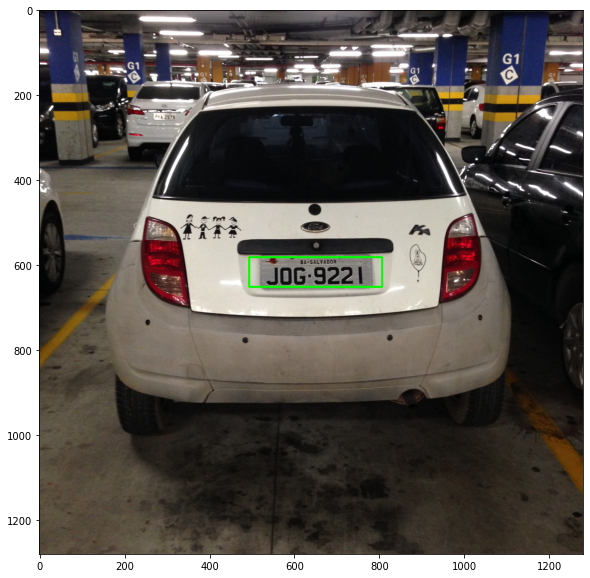

In [24]:
# Import necessary modules
import matplotlib
import matplotlib.pyplot as plt
for pred in predictions:
  drawPred(test_img, pred)
# Display inference
fig=plt.figure(figsize=(10, 10))
plt.imshow(test_img[:,:,::-1])